# Russian Layout Optimization with Bigrams

In [2]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd
from collections import defaultdict

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
    - [Finger Load Comparison](#finger-load)
    - [Which Rows do Keys Gravitate to](#rows-gravitation)
    - [Bigrams vs Position Penalties](#bigram-position-chart)
- [Test your layout here](#your-layout)
    - [Export any layout to Linux XKB](#export-to-xkb)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [114]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt', '../we.txt', types={'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'})

In [115]:
CORP.bigrams

bigram   num l1 l2 t1 t2          freq
0        ¶м   192  ¶  м  -  c  1.593387e-04
1        мо  4262  м  о  c  v  3.536988e-03
2        ож  2339  о  ж  v  c  1.941111e-03
3        же  3944  ж  е  c  v  3.273083e-03
4        ет  6628  е  т  v  c  5.500506e-03
...     ...   ... .. .. .. ..           ...
2660     юв     1  ю  в  v  c  8.298893e-07
2661     ч;     1  ч  ;  c  -  8.298893e-07
2662     ц¶     1  ц  ¶  c  -  8.298893e-07
2663     у2     1  у  2  v  -  8.298893e-07
2664     ц?     1  ц  ?  c  -  8.298893e-07

[2665 rows x 7 columns]

In [116]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   93113
е   78090
а   70594
и   55193
т   54232
н   45844
р   37937
л   37899
с   33225
в   24457
к   23285
м   22199
у   21934
д   20689
ы   18941
ь   17795
я   16759
й   11203
г   11174
з   11088
ч    9504
б    9040
ж    7572
п    7472
х    7434
ю    6163
ш    6118
щ    3197
ц    3187
ё    1222
ф    1141
э     343
ъ     300

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

freq_out     freq_in      outer   frequency     outerness
ъ   2.456472    0.000000  -2.456472    2.456472 -10000.000000
ы  19.353018    0.024897 -19.328122   19.377915  -9974.304069
ь  10.049959    0.016598 -10.033362   10.066557  -9967.023908
а  54.258162    5.834122 -48.424040   60.092284  -8058.279243
о  44.199904    8.630849 -35.569055   52.830752  -6732.642161
у  14.896513    4.755266 -10.141247   19.651778  -5160.472973
и  61.967833   23.427775 -38.540059   85.395608  -4513.119534
е  22.290826  100.466398  78.175571  122.757224   6368.307193
я   5.037428   51.801690  46.764262   56.839118   8227.478464
э   0.024897    1.643181   1.618284    1.668077   9701.492537
ю   0.406646   36.174874  35.768229   36.581520   9777.676951
ё   0.000000    2.166011   2.166011    2.166011  10000.000000

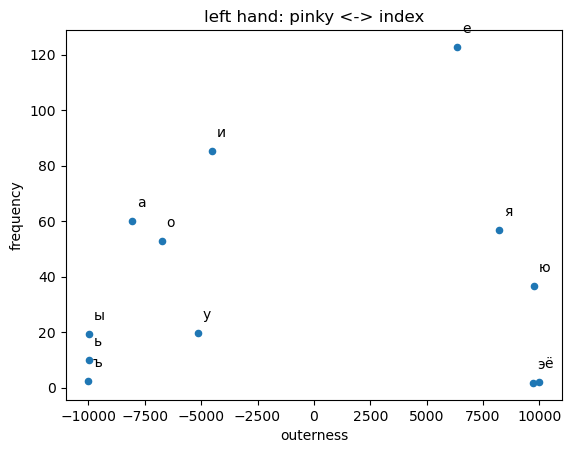

In [117]:
CORP.display_outerness("(t1 == 'v') & (t2 == 'v')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
ц     1.178443    8.174410   -6.995967    9.352852 -7480.035492
щ     0.722004    4.365218   -3.643214    5.087221 -7161.500816
л    23.386280   85.088549  -61.702269  108.474829 -5688.164639
р    49.494597  159.131272 -109.636674  208.625869 -5255.181193
н    62.216800  165.297349 -103.080549  227.514150 -4530.731351
т    98.059719  175.961427  -77.901708  274.021146 -2842.908628
к    44.988299   72.507428  -27.519129  117.495726 -2342.138720
м    23.909111   21.776295    2.132815   45.685406   466.848320
ф     2.431576    2.149413    0.282162    4.580989   615.942029
в    71.270892   60.540424   10.730469  131.811316   814.077945
ш    13.502299   10.647480    2.854819   24.149778  1182.130584
д    56.067321   39.876181   16.191140   95.943501  1687.570279
х     9.145380    5.717937    3.427443   14.863317  2305.974316
ж    20.556358    7.709672   12.846686   28.266029  4544.920728
с   232.908430   83.063619  149.844811  315.972049  4742.343857
г    31.353217   10.572790   20.780428   41.926007  4956.452890
ч    40.614782   12.962871   27.651911   53.577653  5161.090458
п    74.192103   21.021096   53.171007   95.213199  5584.415584
б    28.755664    5.145314   23.610350   33.900978  6964.504284
з    52.457302    4.780162   47.677140   57.237465  8329.708569
й    19.286627    0.008299   19.278328   19.294926  9991.397849

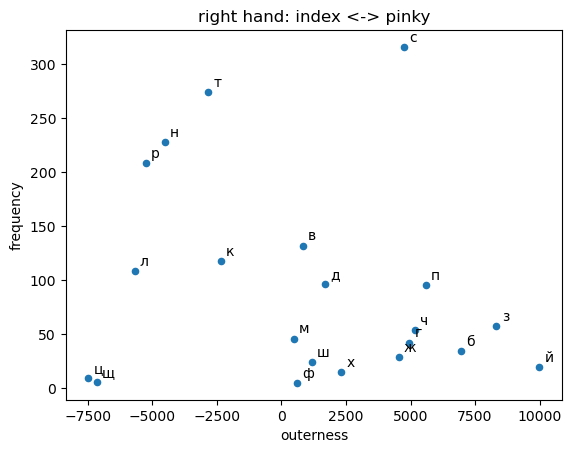

In [118]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [119]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [198]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
753222 6422369
422003 42002368
 10002 2000125
 12213 312213
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [199]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 0abcd3 6ghij9
 001233 6678
e
''',

'''
9752224 422236
7420034 430023
 210002 200012
 412213 3122
0
''',
# 753222 4222369
# 421112 33112368
#  10002 2000125
#  21114 411123
         std_key_shape, STD_EXTRA_KEYS
)

In [200]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32букваП': r'''    
ъ12345 67890-=
→фуыхэ жшвкчзщ/
 поией ,ртнсд¶
 ьаёяю цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест38': r'''
ъ12345 67890-=
→фэыхё жмвкчшц/
 аиое, йртнсз¶
 щьуяю глдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест39': r'''
ъ12345 67890-=
→фёыхэ шмвкчйц/
 аиое, зртнсг¶
 щьуяю жлдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    

'тест40': r'''
ъ12345 67890-=
→фцыёэ шмвкзчх/
 аиое, йртнсг¶
 щьуяю жлдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
 
'тест41': r'''
ъ12345 67890-=
→фцыёэ швкдгжх/
 аоие, лрнтсз¶
 щьуяю ймбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест42': r'''
ъ12345 67890-=
→фыцэё шбвдгжх/
 аоие, лрнтсз¶
 щьуяю ймкпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест43': r'''
ъ12345 67890-=
→эыцёх шбвдгжф/
 аоие, лрнтсз¶
 щьуяю ймкпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
}

    

In [201]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 3.1362
key """ repeated: 2
key "?" repeated: 2
layout usphonetic: 3.4514
layout rusdvorak: 1.756
key ":" repeated: 2
layout диктор: 1.6103
layout зубачёв: 1.6792
key "." repeated: 2
layout скоропис: 1.5584
key """ repeated: 3
key ";" repeated: 2
key ":" repeated: 2
layout ант: 1.894
layout ugnvs: 2.1709
layout леонов: 1.3088
layout леонов2: 1.2193
layout леонов3: 1.382
layout тест1: 2.873
layout тест2: 2.5238
layout тест3: 2.233
layout тест4: 1.9951
layout тест5: 1.8366
layout тест6: 1.9041
layout тест7: 1.9147
layout тест8: 1.8632
layout тест9: 1.8688
layout тест10: 1.8095
layout тест11: 1.8262
layout тест12: 1.697
layout тест13: 1.6768
layout тест14: 1.6319
layout тест15: 1.5728
layout тест16: 1.5759
layout тест17: 1.5506
layout тест18: 1.5583
layout тест19: 1.5811
layout тест20: 1.5723
layout тест21: 1.5525
layout тест22: 1.5525
layout тест23: 1.5253
layout тест24: 1.526
layout тест25: 1.5417
layout ино1: 1.281
layout тест26: 1.4805
layout тест27: 1.495
layout ино2: 1

# Final Standings <a name="standings">

In [202]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест40', ''),
    ('тест43', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   1.028 | Alien #2, many counterparts on AltGr   |
| ино1       |   1.281 | Alien #1, rare letters on AltGr        |
| леонов     |   1.309 | Leonov                                 |
| тест40     |   1.429 |                                        |
| тест43     |   1.465 | Best and currently in use on my laptop |
| скоропис   |   1.558 | Skoropis                               |
| диктор     |   1.61  | Dictor                                 |
| зубачёв    |   1.679 | Zubachov                               |
| rusdvorak  |   1.756 | Dvorak translit                        |
| тест10     |   1.81  | First optimized after hand testing     |
| тест9      |   1.869 | First hand-tested                      |
| ант        |   1.894 | ANT                                    |
| ugnvs      |   2.171 | UGNVS                   

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000113 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

тест44 : 1.44 


/usr/lib/python3/dist-packages/IPython/core/events.py:93: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)


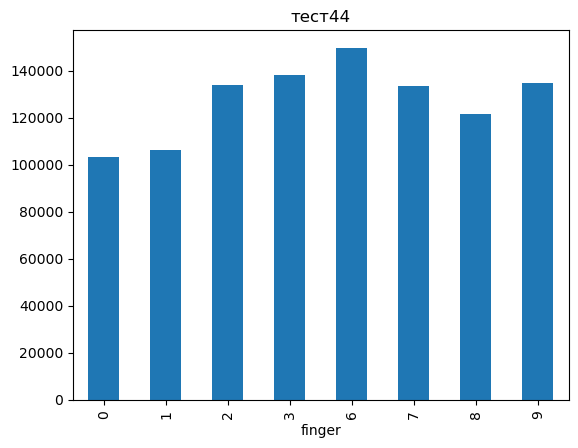

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


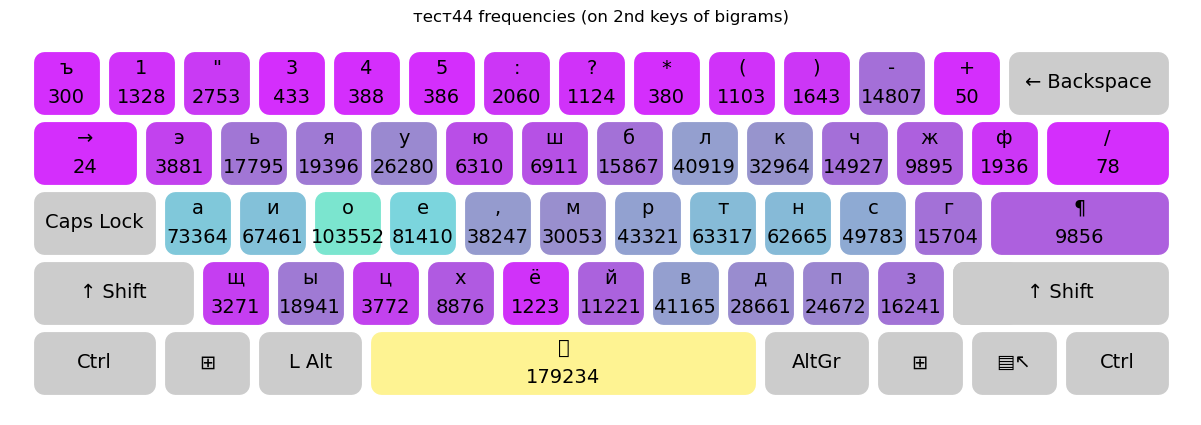

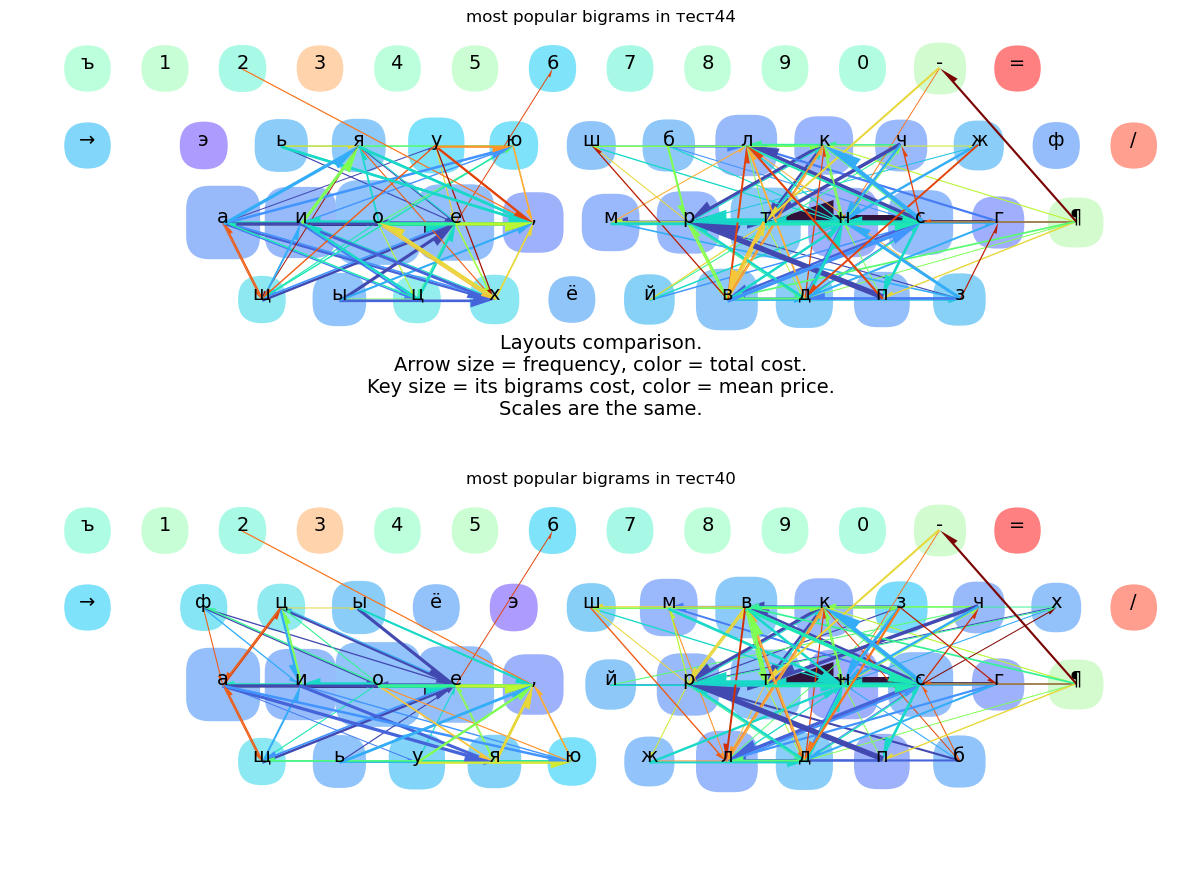

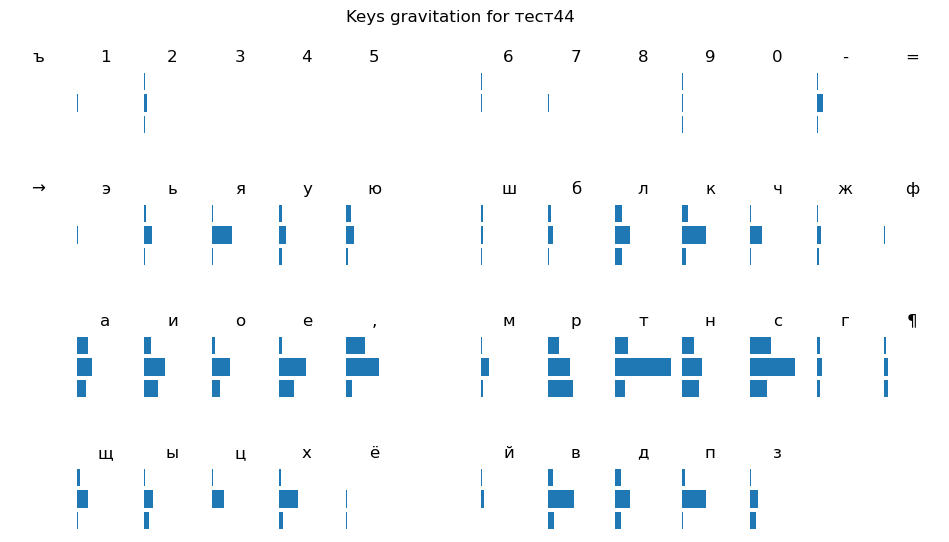

In [228]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест44', (r'''
ъ12345 67890-=
→эьяую шблкчжф/
 аиое, мртнсг¶
 щыцхё йвдпз
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

r.load_bars()
r.display('freq')
r.combomap(results['тест40'])
r.display('rows')

In [215]:
r.bigrams[r.bigrams.l2 == 'л'].sort_values('num', ascending=False)

bigram   num l1 l2 t1 t2          freq  row1  column1  row2  ...  \
93       ал  6648  а  л  v  c  5.517104e-03     2        1     1  ...   
88       ол  6459  о  л  v  c  5.360255e-03     2        3     1  ...   
45       ел  6391  е  л  v  c  5.303822e-03     2        4     1  ...   
24       ил  4248  и  л  v  c  3.525370e-03     2        2     1  ...   
57       сл  2912  с  л  c  c  2.416638e-03     2       11     1  ...   
6        ⌴л  2872  ⌴  л  -  c  2.383442e-03     4        0     1  ...   
226      ыл  1647  ы  л  v  c  1.366828e-03     3        2     1  ...   
347      ул  1488  у  л  v  c  1.234875e-03     1        4     1  ...   
491      гл  1141  г  л  c  c  9.469037e-04     2       12     1  ...   
252      пл  1062  п  л  c  c  8.813424e-04     3       10     1  ...   
346      бл  1031  б  л  c  c  8.556159e-04     1        8     1  ...   
338      вл   897  в  л  c  c  7.444107e-04     3        8     1  ...   
500      дл   781  д  л  c  c  6.481435e-04     3        9     1  ...   
363      кл   692  к  л  c  c  5.742834e-04     1       10     1  ...   
97       ял   575  я  л  v  c  4.771863e-04     1        3     1  ...   
285      шл   434  ш  л  c  c  3.601720e-04     1        7     1  ...   
794      мл   274  м  л  c  c  2.273897e-04     2        7     1  ...   
530      лл   245  л  л  c  c  2.033229e-04     1        9     1  ...   
535      тл   209  т  л  c  c  1.734469e-04     2        9     1  ...   
568      зл   208  з  л  c  c  1.726170e-04     3       11     1  ...   
665      хл   143  х  л  c  c  1.186742e-04     1       12     1  ...   
323      эл   113  э  л  v  c  9.377749e-05     1        1     1  ...   
421      рл   103  р  л  c  c  8.547860e-05     2        8     1  ...   
957      -л    63  -  л  -  c  5.228303e-05     0       12     1  ...   
567      ёл    58  ё  л  v  c  4.813358e-05     3        4     1  ...   
1493     ¶л    56  ¶  л  -  c  4.647380e-05     2       13     1  ...   
1041     фл    47  ф  л  c  c  3.900480e-05     1       13     1  ...   
1314     йл    40  й  л  c  c  3.319557e-05     3        5     1  ...   
864      "л    20  "  л  -  c  1.659779e-05     0        2     1  ...   
2331     юл    19  ю  л  v  c  1.576790e-05     1        5     1  ...   
1252     чл    15  ч  л  c  c  1.244834e-05     1       11     1  ...   
1388     жл    11  ж  л  c  c  9.128782e-06     3        7     1  ...   
1328     (л     8  (  л  -  c  6.639114e-06     0       10     1  ...   
1335     нл     7  н  л  c  c  5.809225e-06     2       10     1  ...   
590      цл     1  ц  л  c  c  8.298893e-07     3        3     1  ...   
2373     .л     1  .  л  -  c  8.298893e-07     2        5     1  ...   

                  move_cat  voff hoff  row column  finger  ftype  hand  \
93    alternating or space   0.5  0.0    1      9       7      2     1   
88    alternating or space   0.5  0.0    1      9       7      2     1   
45    alternating or space   0.5  0.0    1      9       7      2     1   
24    alternating or space   0.5  0.0    1      9       7      2     1   
57                      ok   1.0  0.0    1      9       7      2     1   
6     alternating or space   0.5  0.0    1      9       7      2     1   
226   alternating or space   0.5  0.0    1      9       7      2     1   
347   alternating or space   0.5  0.0    1      9       7      2     1   
491                     ok   1.0  1.0    1      9       7      2     1   
252                     ok   2.0  0.0    1      9       7      2     1   
346                     ok   0.0  0.0    1      9       7      2     1   
338                     ok   2.0  0.0    1      9       7      2     1   
500                     ok   2.0  0.0    1      9       7      2     1   
363                     ok   0.0  0.0    1      9       7      2     1   
97    alternating or space   0.5  0.0    1      9       7      2     1   
285                     ok   0.0  1.0    1      9       7      2     1   
794                     ok   1.0  1.0    1   

check which side and row letters gravitate to in a layout result (this depends on corpus stats, hence it should be done in a Result instance)


## Finger Load Comparison <a name='finger-load'/>

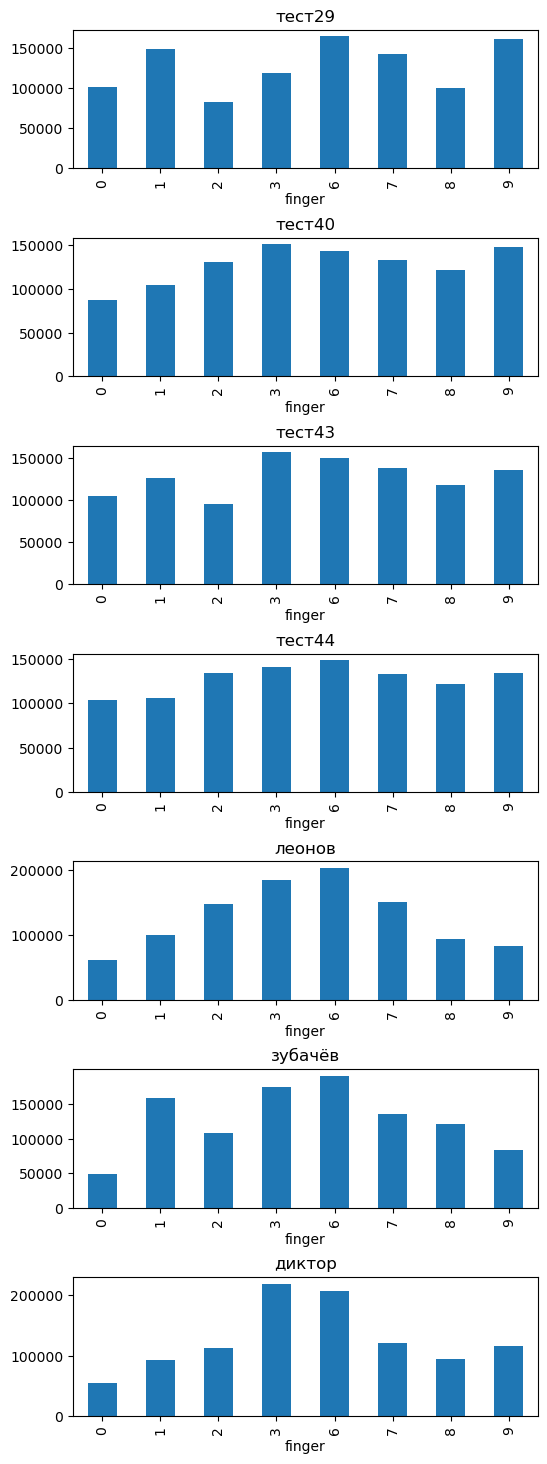

In [216]:
keys = ('тест29', 'тест40', 'тест43', 'тест44', 'леонов', 'зубачёв', 'диктор')
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(keys), 1, figsize=(6, 18))
plt.subplots_adjust(hspace=.5)

for k, ax in zip(keys, axs):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d.plot.bar(ax=ax, title=k, legend=False)

## Which Rows do Keys Gravitate to <a name='rows-gravitation'>
    
In this chart, we show how many bigrams do letters have with rows 1-3 (main key rows). If a key in bottom row has most bigrams in bottom or middle row, it's fine in that position. This chart actually shows that almost all letters are in their best places.
    
note: This calculation excludes combos with keys on another hand, and with the key itself (НН is quite popular that it distorts the stats significantly).

Letter В (v) may gain a little bit in the bottom row, but letters in that row will loose more.

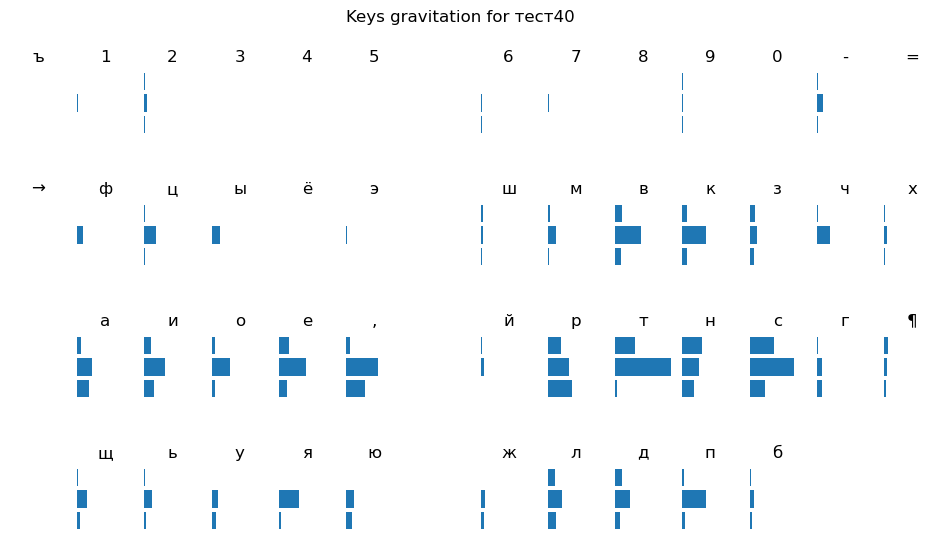

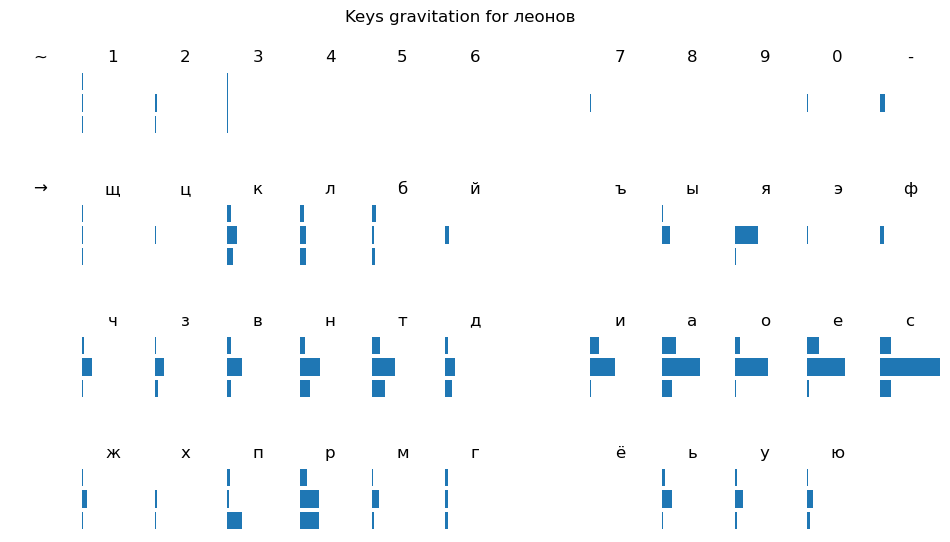

In [217]:
results['тест40'].display('rows')
results['леонов'].display('rows')

# Bigrams vs Position Penalties <a name='bigram-position-chart'/>

### Theoretical minimal score

This calculation shows how low could the score be if we put keys ordered by frequencies, and there were no bigrams penalties:

In [218]:
pos_penalties = STANDARD_KBD.keymap['penalty'].values
pos_penalties.sort()
freqs = CORP.bigrams.groupby('l2').agg({'freq': 'sum'}).sort_values('freq', ascending=False).values
min_score = sum(a * b for a, b in zip(freqs, pos_penalties))[0]
min_score

0.684627130740759

name    pos   move  coord  bigram  pareto_opt
0       йцукен  1.362  0.871  1.584   2.455       False
1   usphonetic  1.218  1.095  1.747   2.842       False
2    rusdvorak  1.026  0.510  0.733   1.243       False
3       диктор  0.869  0.575  0.601   1.176       False
4      зубачёв  0.765  0.612  0.684   1.297        True
5          ант  0.974  0.744  0.663   1.407       False
6        ugnvs  0.856  0.518  1.225   1.743       False
7       леонов  0.784  0.362  0.555   0.917        True
8        тест1  1.362  0.885  1.307   2.192       False
18      тест11  1.178  0.724  0.513   1.237       False
34      тест27  0.908  0.578  0.463   1.041        True
39      тест32  0.792  0.527  0.536   1.063        True
46      тест38  0.805  0.522  0.518   1.041        True
47      тест39  0.801  0.520  0.518   1.038        True
48      тест40  0.834  0.527  0.485   1.012        True
49      тест41  0.862  0.526  0.486   1.013       False
50      тест42  0.867  0.526  0.501   1.027       False
51      тест43  0.855  0.517  0.521   1.038       False

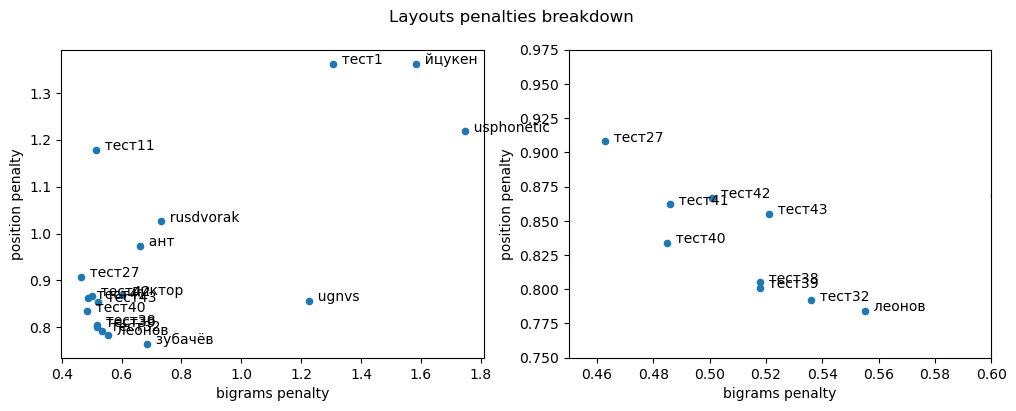

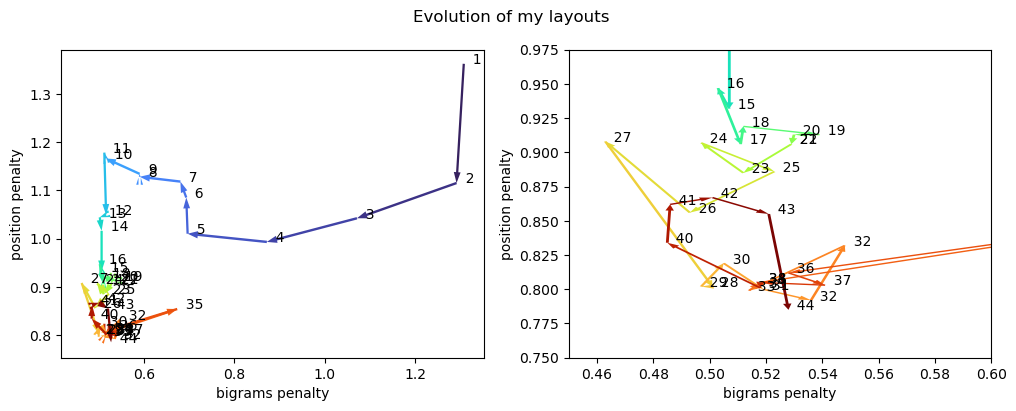

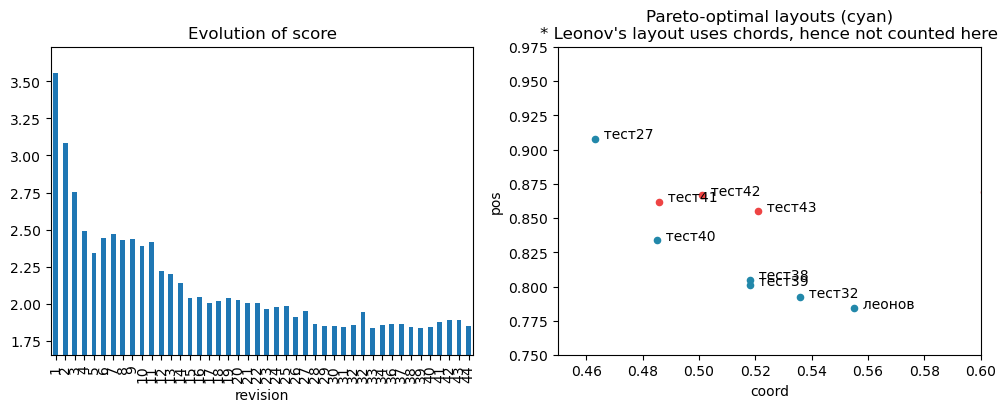

In [219]:
xlims = (.45, .6)
ylims = (.75, 0.975)

dd = []
for k, v in results.items():
#    if k.startswith('тест') and not k.startswith('тест37'): continue
    if k.startswith('леонов') and not k == 'леонов': continue
    if k.startswith('ино'): continue
    if k.startswith('скоропис'): continue
    b = results[k].bigrams
    bgcost = b.coord_cost + b.move_cost
    dd.append({
        'name': k, 
        'pos': round((b.penalty * b.num).sum() / b.num.sum(), 3),
        'move': round((b.move_cost * b.num).sum() / b.num.sum(), 3),
        'coord': round((b.coord_cost * b.num).sum() / b.num.sum(), 3),
        'bigram': round((bgcost * b.num).sum() / b.num.sum(), 3)
    })
    
df2 = pd.DataFrame(dd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
lims = (0.6, 1.0)
# selecting layouts to display their scores
df3 = df2[~df2.name.str.startswith('тест') | df2.name.isin([
    'тест43', 'тест42', 'тест41', 'тест40', 'тест39', 'тест38', 'тест32', 'тест27', 'тест1', 'тест11'])].copy()
for ax in (ax1, ax2):
    df3.plot.scatter(x='coord', y='pos', ax=ax)
    for i, rw in df3.iterrows():
        ax.annotate('  ' + str(rw['name']), (rw.coord, rw.pos))

    for a in (ax1, ax2):
        a.set_xlabel('bigrams penalty')
        a.set_ylabel('position penalty')

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)
        
fig.suptitle('Layouts penalties breakdown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Evolution of my layouts')

import re
df4 = df2[df2.name.apply(lambda k: re.match(r'тест(\d+)', k) is not None)].copy()
df4['revision'] = df4.name.apply(lambda k: int(re.match(r'тест(\d+)', k).groups()[0]))
df4.sort_values('revision', inplace=True)
df4['pos1'] = df4.pos.diff(-1)
df4['coord1'] = df4.coord.diff(-1)
df4['bigram1'] = df4.bigram.diff(-1)
maxnum = df4.revision.max() - 1

for ax, w in zip((ax1, ax2), (.005, .001)):
    ax.set_xlabel('bigrams penalty')
    ax.set_ylabel('position penalty')
    for _, rw in df4.iterrows():
        ax.arrow(
            rw['coord'], rw['pos'], -rw['coord1'], -rw['pos1'],
            width=w,
            length_includes_head=True, ec='#00000000',
            color=plt.cm.turbo(rw.revision / maxnum)
        )
        ax.annotate(f'  {rw["revision"]}', (rw['coord'], rw['pos']))

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df5 = df4[df4.revision != 35].set_index('revision')
scores = (df5['pos'] + df5['bigram'])
scores.plot.bar(ax=ax1, title='Evolution of score')
ax1.set_ylim(scores.min() * .9, scores.max() * 1.05)

df3['pareto_opt'] = df3.apply(lambda row: len(df3[(df3.pos < row.pos) & (df3.coord < row.coord) & (df3.name != 'леонов')]) == 0, axis=1)

df3[df3.pareto_opt].plot.scatter(x='coord', y='pos', color='#2288aa', marker='o', ax=ax2)
df3[~df3.pareto_opt].plot.scatter(x='coord', y='pos', color='#ee4444', marker='o', ax=ax2)
for _, rw in df3.iterrows():
    ax2.annotate(f'  {rw["name"]}', (rw['coord'], rw['pos']))

ax2.set_title('Pareto-optimal layouts (cyan)\n* Leonov\'s layout uses chords, hence not counted here')
ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)

df3

How to read the charts above:

* Layout penalties
    * dots on the left have more convenient roll-ins (or alternating hands
    * dots in the bottom have fingers work more in home position
* Evolution of my layouts: dimensions are the same
    * notice: the criteria for convenience were different.
    * some layouts move up-left -- these were optimizations of bigrams that turned out worse in real testing, because some awkward position wasn't penalized.
* Evolution of score (bottom)
    * Local peaks were revisions where improvement of score made the layout noteably worse in typing test. Score rules were then updated, and after that, the revision scored worse than previous ones.

Notes:

1. A complete improvement (within the scoring system) is when a layout is both lower and to the left of the other one.
2. If two layouts are on a line from left-up to right-down, then they have tradeoffs, none is better.
3. The best layouts are 41, 42, 39 and 32 (if we exclude `леонов` that uses chords). All other layouts are worse than theese (they have both scores worse).
4. Scores started to be changed starting from layout 10.
5. Layout 35 was an attempt to move vowels on the right side.
6. Leonov's layout has comma and period on chords, hence it spares a good deal of penalty (costs of chording aren't calculated).



(0.3, 0.6)

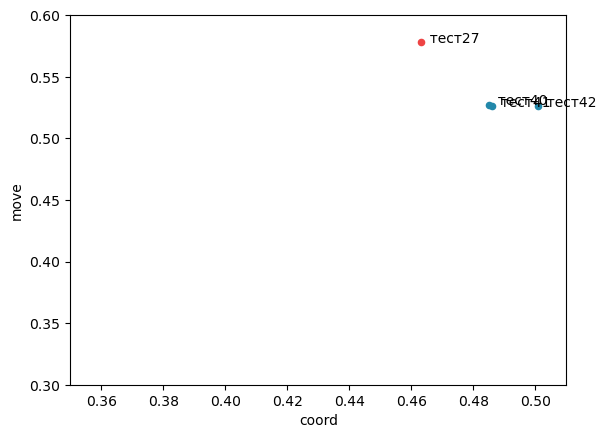

In [220]:
df3['pareto_opt'] = df3.apply(lambda row: len(df3[(df3.move < row.move) & (df3.bigram < row.bigram) & (df3.name != 'леонов')]) == 0, axis=1)

ax2 = df3[df3.pareto_opt].plot.scatter(x='coord', y='move', color='#2288aa', marker='o')
df3[~df3.pareto_opt].plot.scatter(x='coord', y='move', color='#ee4444', marker='o', ax=ax2)
for _, rw in df3.iterrows():
    ax2.annotate(f'  {rw["name"]}', (rw['coord'], rw['move']))
ax2.set_xlim(0.35, 0.51)
ax2.set_ylim(0.3, 0.6)

# Export Your Or Other Layout to Linux xkb <a name='export-to-xkb'/>

Run the next cell, and it will output layout variant block. You should copy and paste it into some `/usr/share/X11/xkb/symbols/*` file. To show it in layouts, add it to `/usr/share/X11/xkb/rules/evdev.xml`:

```
    <layout>
      <configItem>
        <name>[name of the file in symbols]</name>
        <shortDescription>ru</shortDescription>
        <description>Russian</description>
        <countryList>
          <iso3166Id>RU</iso3166Id>
          <iso3166Id>KZ</iso3166Id>
        </countryList>
        <languageList>
          <iso639Id>rus</iso639Id>
        </languageList>
      </configItem>
      <variantList>
        <variant>
          <configItem>
            <name>[the same name as in xkb_symbols "<name>"]</name>
            <description>[title]</description>
          </configItem>
        </variant>
      </variantList>
    </layout>
```

In [221]:
results['тест44'].layout.export()


default partial alphanumeric_keys
xkb_symbols "тест44" {
	include "ru(common)"
	name[Group1]= "Culebron (тест44)";
	
	key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };


	key <AD01> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD02> { [ Cyrillic_softsign, Cyrillic_SOFTSIGN ] };
	key <AD03> { [ Cyrillic_ya, Cyrillic_YA ] };
	key <AD04> { [ Cyrillic_u, Cyrillic_U ] };
	key <AD05> { [ Cyrillic_yu, Cyrillic_YU ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_be, Cyrillic_BE ] };
	key <AD08> { [ Cyrillic_el, Cyrillic_EL ] };
	key <AD09> { [ Cyrillic_ka, Cyrillic_KA ]

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

bigram   num                coord_cat_old  coord_cost_old  move_cost_old  \
78      тр  4206  in, over 1 finger, same row               0            0.0   
184     ое  2566  in, over 1 finger, same row               0            0.0   
164     о,  2155  in, over 1 finger, same row               0            0.0   
133     ⌴ч  5221                    space bar               0            0.5   
227     ⌴д  7563                    space bar               0            0.5   
447     зд  1200      pinky -> ring, next row               3            1.0   
196     зн  2125  in, over 1 finger, same row               0            0.0   
411     дн  2087                in, lower row               1            0.0   
195     од  5836                 altern hands               0            0.5   
49      тв  2554      in, adj finger, adj row               4            0.0   
96      оя   711   in, over 1 finger, adj row               1            0.0   
317     о.  1122  in, over 1 finger, same row               0            0.0   
407     сн  1050  in, over 1 finger, same row               0            0.0   
114     ск  4041   in, over 1 finger, adj row               1            0.0   
387     жн  1344   in, over 1 finger, adj row               1            0.0   
402     ⌴х  1339                    space bar               0            1.0   
512     др  1275   in, over 1 finger, adj row               1            0.0   
25      ⌴м  7503                    space bar               0            0.5   
274     ах  1203   in, over 1 finger, adj row               1            0.0   
289     ац   451      pinky -> ring, next row               3            0.0   
412     дв   848      in, adj finger, adj row               4            1.0   
182     ⌴э  3333                    space bar               0            0.5   
345     рн  1093       index->middle same row               1            0.0   
248     ед  2965                 altern hands               0            0.5   
100     оч  1894                 altern hands               0            0.5   
191     ом  5523                 altern hands               0            0.5   
231     ци  1315                in, lower row               1            0.0   
509     фа   260                 altern hands               0            0.0   
235     чн  1297   in, over 1 finger, adj row               1            0.0   
219     ич  1685                 altern hands               0            0.5   

             move_cat_old  cost_old                          coord_cat_new  \
78                     ok       0.0                in, adj finger, adj row   
184                    ok       0.0                in, adj finger, adj row   
164                    ok    2155.0                in, adj finger, adj row   
133  alternating or space    5221.0                              space bar   
227  alternating or space    3781.5                              space bar   
447                    ok    4800.0              over 1 finger, over 1 row   
196                    ok       0.0                pinky -> ring, next row   
411                    ok    2087.0                   out, over one finger   
195  alternating or space    2918.0                           altern hands   
49                     ok   10216.0                    same finger adj row   
96                     ok    1066.5  in, middle to to index in a row above   
317                    ok    1122.0                in, adj finger, adj row   
407                    ok       0.0                in, adj finger, adj row   
114                    ok    8082.0                pinky -> ring, next row   
387                    ok    1344.0                   out, over one finger   
402  alternating or space    3347.5                              space bar   
512                    ok    1275.0  in, middle to to index in a row below   
25   alternating or space    7503.0                              space bar   
274                    ok    3007.5      

/usr/lib/python3/dist-packages/IPython/core/events.py:93: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


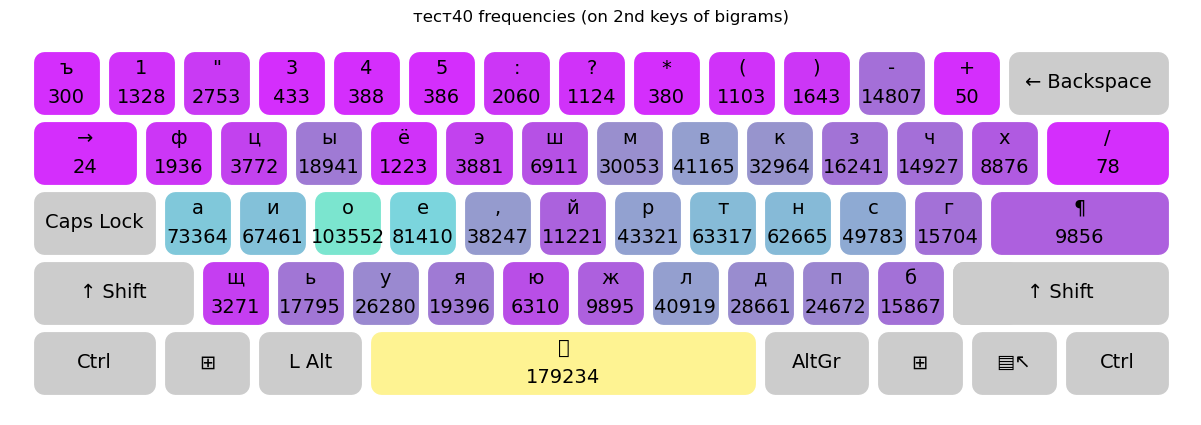

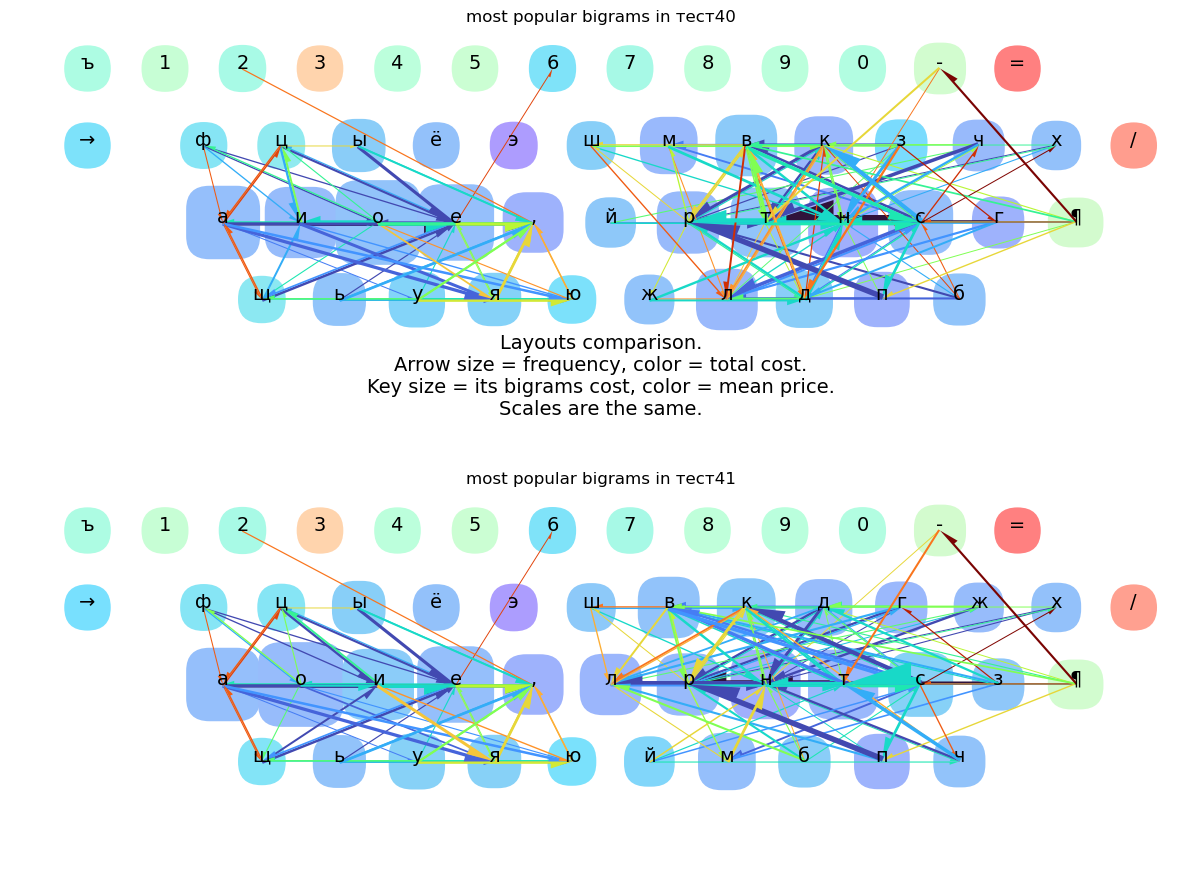

In [222]:
k = 'тест40'
results[k].display('num')
results[k].combomap(results['тест41'])
results['тест43'].compare(results[k]).sort_values('delta', ascending=False).head(30)

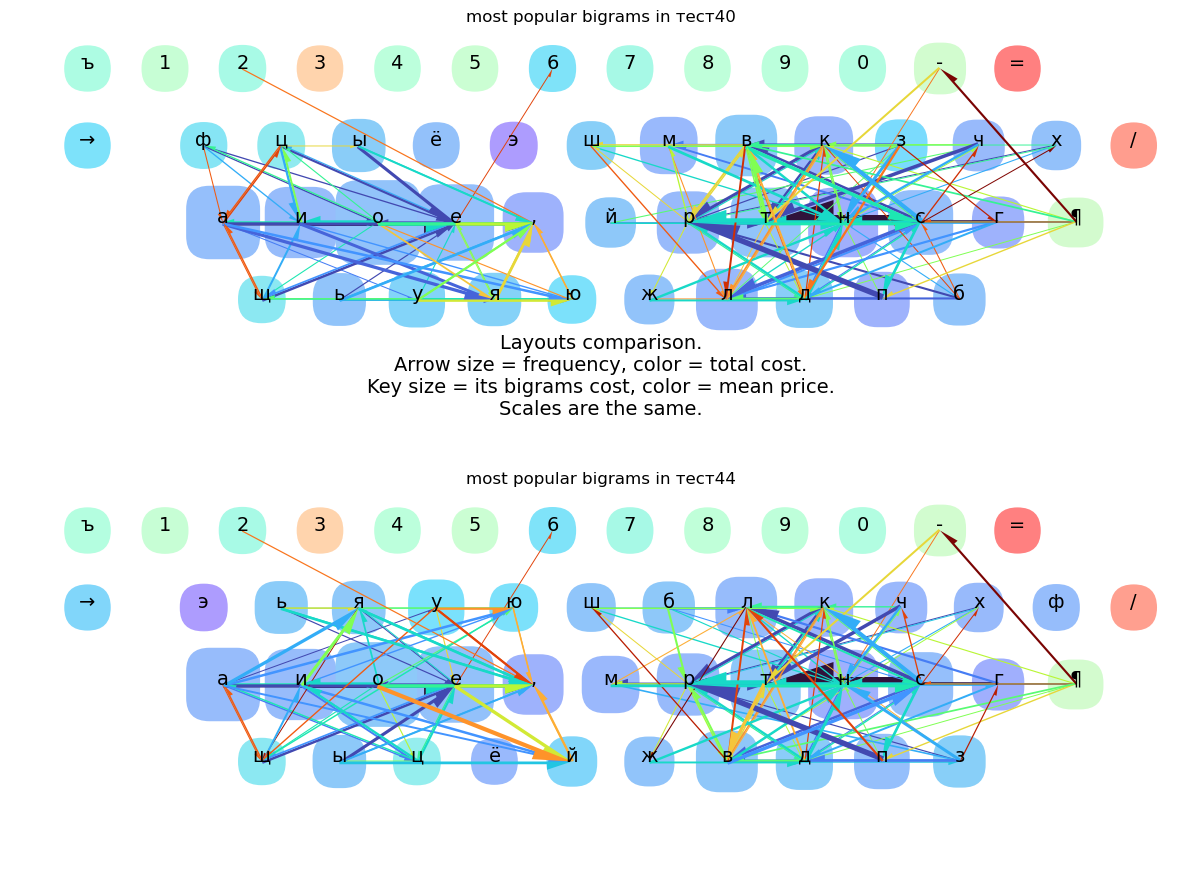

In [223]:
results['тест40'].combomap(results['тест44'])

## Losses

In [189]:
compare(results, 'тест42', 'тест43').head(30)

bigram   num               coord_cat_old  coord_cost_old  move_cost_old  \
194      хо  2053                altern hands               0            0.0   
142      х,   520                altern hands               0            0.5   
309      ⌴ф   736                   space bar               0            0.5   
657      ух   373                altern hands               0            2.5   
488      х.   301                altern hands               0            0.5   
443      ху   192                altern hands               0            0.5   
182      ⌴э  3333                   space bar               0            1.0   
473      ях   278                altern hands               0            2.5   
695      ¶ф    41                altern hands               0            0.5   
336      ха   580                altern hands               0            0.0   
674      хи   288                altern hands               0            0.0   
141      ех   597                altern hands               0            2.5   
965      фф    27                    same key               0            1.0   
628      нф   120                altern hands               0            0.5   
968      х:    23                altern hands               0            6.5   
1204     аэ    50  in, over 1 finger, adj row               1            0.0   
595      щё   151   pinky -> index over 1 row               4            2.0   
779      хе    63                altern hands               0            0.0   
791      -ф    10                altern hands               0            0.5   
906      ёх    93                altern hands               0            2.5   
1039     сф    28                altern hands               0            0.5   
1275     х"    28                altern hands               0            2.5   
981      фл    47                altern hands               0            0.5   
526      оэ   129     in, adj finger, adj row               4            0.0   
770      тф    32                altern hands               0            0.5   
754      мф    22                altern hands               0            0.5   
264      еф    73              index -> pinky               2            0.0   
931      фс    17                altern hands               0            0.0   
1647     юх    22                altern hands               0            2.5   
280      фр   165                altern hands               0            0.0   

              move_cat_old  cost_old  \
194   alternating or space       0.0   
142   alternating or space     780.0   
309   alternating or space    1104.0   
657   alternating or space    2051.5   
488   alternating or space     451.5   
443   alternating or space     288.0   
182   alternating or space    3333.0   
473   alternating or space    1529.0   
695   alternating or space      61.5   
336   alternating or space     290.0   
674   alternating or space       0.0   
141   alternating or space    3283.5   
965                     ok      54.0   
628   alternating or space     180.0   
968   alternating or space     218.5   
1204                    ok      50.0   
595                     ok    1057.0   
779   alternating or space       0.0   
791   alternating or space      15.0   
906   alternating or space     511.5   
1039  alternating or space      42.0   
1275  alternating or space     112.0   
981   alternating or space      70.5   
526                     ok     516.0   
770   alternating or space      48.0   
754   alternating or space      33.0   
264                     ok     219.0   
931   alternating or space       8.5   
1647  alternating or space     121.0   
280   alternating or space       0.0   

                                  coord_cat_new  coord_cost_new  \
194                        out, over one finger               4   
142                         same finger adj row               6   
309                                   space bar               0   
657            

## Gains

In [190]:
compare(results, 'тест42', 'тест43').tail(30)

bigram   num                coord_cat_old  coord_cost_old  move_cost_old  \
1556     хг    17                pinky adj row              10            5.0   
1236     х?    13   in, over 1 finger, adj row               1           20.0   
1020     х)    10                pinky adj row              10           20.0   
609      хн   281   in, over 1 finger, adj row               1            0.0   
1008     (х    11      ring -> pinky, next row               5           20.0   
629      фе   398   in, over 1 finger, adj row               1            0.0   
193      вх    41         out, over one finger               4            5.0   
265      фи   415   in, over 1 finger, adj row               1            0.0   
910      фы    44                pinky adj row              10            2.0   
577      хс    51                pinky adj row              10            0.0   
699      бх    64               index -> pinky               2            5.0   
782      х¶    21                pinky adj row              10           20.0   
710      дх    65         out, over one finger               4            5.0   
562      рх   226               index -> pinky               2            0.0   
310      фу    89    over 1 finger, over 1 row               8            1.0   
649      хл   143   in, over 1 finger, adj row               1            5.0   
71       ых  1632                 altern hands               0            2.5   
1143     ¶х    28                pinky adj row              10           20.0   
685      аф   169                pinky adj row              10            0.0   
698      хв   211  in, over 1 finger, same row               0            5.0   
111      их  2015                 altern hands               0            2.5   
907      хм   123    pinky -> index over 1 row               4            5.0   
508      фо   385      pinky -> ring, next row               3            0.0   
679      х-    38                pinky adj row              10           25.0   
316      ох   514                 altern hands               0            2.5   
627      -х    50                pinky adj row              10           25.0   
509      фа   260                pinky adj row              10            0.0   
269      сх   238                pinky adj row              10            0.0   
274      ах  1203                 altern hands               0            2.5   
402      ⌴х  1339                    space bar               0            2.5   

              move_cat_old  cost_old                          coord_cat_new  \
1556                    ok     272.0                           altern hands   
1236                    ok     299.0                           altern hands   
1020                    ok     315.0                           altern hands   
609                     ok     281.0                           altern hands   
1008                    ok     308.0                           altern hands   
629                     ok     398.0                           altern hands   
193                     ok     492.0                           altern hands   
265                     ok     415.0                           altern hands   
910                     ok     550.0                           altern hands   
577                     ok     535.5                           altern hands   
699                     ok     640.0                           altern hands   
782                     ok     682.5                           altern hands   
710                     ok     780.0                           altern hands   
562                     ok    1130.0                           altern hands   
310                     ok     890.0                           altern hands   
649                     ok    1001.0                           altern hands   
71    alternating or space    8976.0            in, over 1 finger, same row   
1143                    ok     924.0                           altern h

You can save the comparison table to CSV:

In [191]:
compare(results, 'леонов', 'тест43').to_csv('leonov-test43.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [192]:
results['тест43'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  row1  column1  row2  ...  \
125     --   5731  -  -  -  -  0.004756     0       12     0  ...   
53      ¶¶   3004  ¶  ¶  -  -  0.002493     2       13     2  ...   
48      ст  13250  с  т  c  c  0.010996     2       11     2  ...   
802     ¶-   1075  ¶  -  -  -  0.000892     2       13     0  ...   
124     ⌴-   5415  ⌴  -  -  -  0.004494     4        0     0  ...   
40      ⌴п  16445  ⌴  п  -  c  0.013648     4        0     3  ...   
262     ия   2162  и  я  v  v  0.001794     2        3     3  ...   
177     .¶   3922  .  ¶  -  -  0.003255     2        5     2  ...   
272     е,   2285  е  ,  v  -  0.001896     2        4     2  ...   
152     мн   1740  м  н  c  c  0.001444     3        8     2  ...   
30      ⌴к   9125  ⌴  к  -  c  0.007573     4        0     3  ...   
132     я,   1664  я  ,  v  -  0.001381     3        4     2  ...   
465     вс   2892  в  с  c  c  0.002400     1        9     2  ...   
155     ие   2865  и  е  v  v  0.002378     2        3     2  ...   
181     ой   4181  о  й  v  c  0.003470     2        2     3  ...   
300     и,   2090  и  ,  v  -  0.001734     2        3     2  ...   
38      ть   6899  т  ь  c  v  0.005725     2       10     3  ...   
49      тв   2554  т  в  c  c  0.002120     2       10     1  ...   
111     их   2015  и  х  v  c  0.001672     2        3     1  ...   
93      ал   6648  а  л  v  c  0.005517     2        1     2  ...   
225     ⌴б   6642  ⌴  б  -  c  0.005512     4        0     1  ...   
88      ол   6459  о  л  v  c  0.005360     2        2     2  ...   
378     ую   1288  у  ю  v  v  0.001069     3        3     3  ...   
45      ел   6391  е  л  v  c  0.005304     2        4     2  ...   
459     -т    950  -  т  -  c  0.000788     0       12     2  ...   
338     вл    897  в  л  c  c  0.000744     1        9     2  ...   
186     вн   1452  в  н  c  c  0.001205     1        9     2  ...   
134     чт   2899  ч  т  c  c  0.002406     3       11     2  ...   
365     е.   1232  е  .  v  -  0.001022     2        4     2  ...   
130     тс   1898  т  с  c  c  0.001575     2       10     2  ...   

                 move_cat  voff hoff  row column  finger  ftype  hand  \
125                    ok   0.0  0.0    0     12       9      4     1   
53                     ok   0.0  0.0    2     13       9      4     1   
48                     ok   0.0  0.0    2     10       8      3     1   
802                    ok   2.0  1.0    0     12       9      4     1   
124  alternating or space   1.0 -0.5    0     12       9      4     1   
40   alternating or space  -0.5  0.0    3     10       8      3     1   
262                    ok   1.0  0.0    3      4       3      1     0   
177  alternating or space   0.0 -1.0    2     13       9      4     1   
272                    ok   0.0  1.0    2      5       3      1     0   
152                    ok   1.0  0.0    2      9       7      2     1   
30   alternating or space  -0.5  0.0    3      9       7      2     1   
132                    ok   1.0  1.0    2      5       3      1     0   
465                    ok   1.0  0.0    2     11       9      4     1   
155                    ok   0.0  0.0    2      4       3      1     0   
181  alternating or space  -0.5  0.5    3      7       6      1     1   
300                    ok   0.0  1.0    2      5       3      1     0   
38   alternating or space  -0.5  0.0    3      2       1      3     0   
49                     ok   1.0  0.0    1      9       7      2     1   
111                    ok   1.0  1.0    1      5       3      1     0   
93   alternating or space   0.0  0.5    2      7       6      1     1   
225  alternating or space   0.5  0.0    1      8       6      1     1   
88   alternating or space   0.0  0.5    2      7       6      1     1   
378                    ok   0.0  1.0    3      5       3      1     0   
45   alternating or space   0.0  0.5    2      7       6      1     1   
459                    ok   2.0  1.0   

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [193]:
key = 'тест43'
res = results[key]

keys_df = (res.layout.keymap[['row', 'column']]
 .reset_index()
 .merge(res.layout.keyboard.keymap, on=['row', 'column'])
).set_index('index')


b1 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_self', '_other')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_self', 'column_self', 'row_other', 'column_other'], right_index=True
    )
b1['kind'] = 'forward'
b1.rename(columns={'l1': 'self', 'l2': 'other', 'hand2': 'hand_other', 'hand1': 'hand_self',
                   't1': 'type_self', 't2': 'type_other'}, inplace=True)

b2 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_other', '_self')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_other', 'column_other', 'row_self', 'column_self'], right_index=True
    )
b2['kind'] = 'backward'
b2.rename(columns={'l2': 'self', 'l1': 'other', 'hand1': 'hand_other', 'hand2': 'hand_self',
                  't2': 'type_self', 't1': 'type_other'}, inplace=True)

pd.concat([b1, b2]).to_csv(f'all-letters-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [194]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count
ъ      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
ь      0    1       1          1
п      0    1       2          1
у      0    1       3          1
я      0    1       4          1
ю      0    1       5          1
ш      0    1       7          1
б      0    1       8          1
л      0    1       9          1
к      0    1      10          1
ч      0    1      11          1
х      0    1      12          1
ф      0    1      13          1
/      0    1      14          1
а      0    2       1          1
и      0    2       2          1
о      0    2       3          1
е      0    2       4          1
,      0    2       5          1
м      0    2       7          1
р      0    2       8          1
т      0    2       9          1
н      0    2      10          1
с      0    2      11          1
ж      0    2      12          1
¶      0    2      13          1
щ      0    3       1          1
ы      0    3       2          1
ц      0    3       3          1
ё      0    3       4          1
э      0    3       5          1
й      0    3       7          1
в      0    3       8          1
д      0    3       9          1
г      0    3      10          1
з      0    3      11          1
⌴      0    4       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
\      1    1      14          1
.      1    2       5          1

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor with modified punctuation marks, and is omitted.

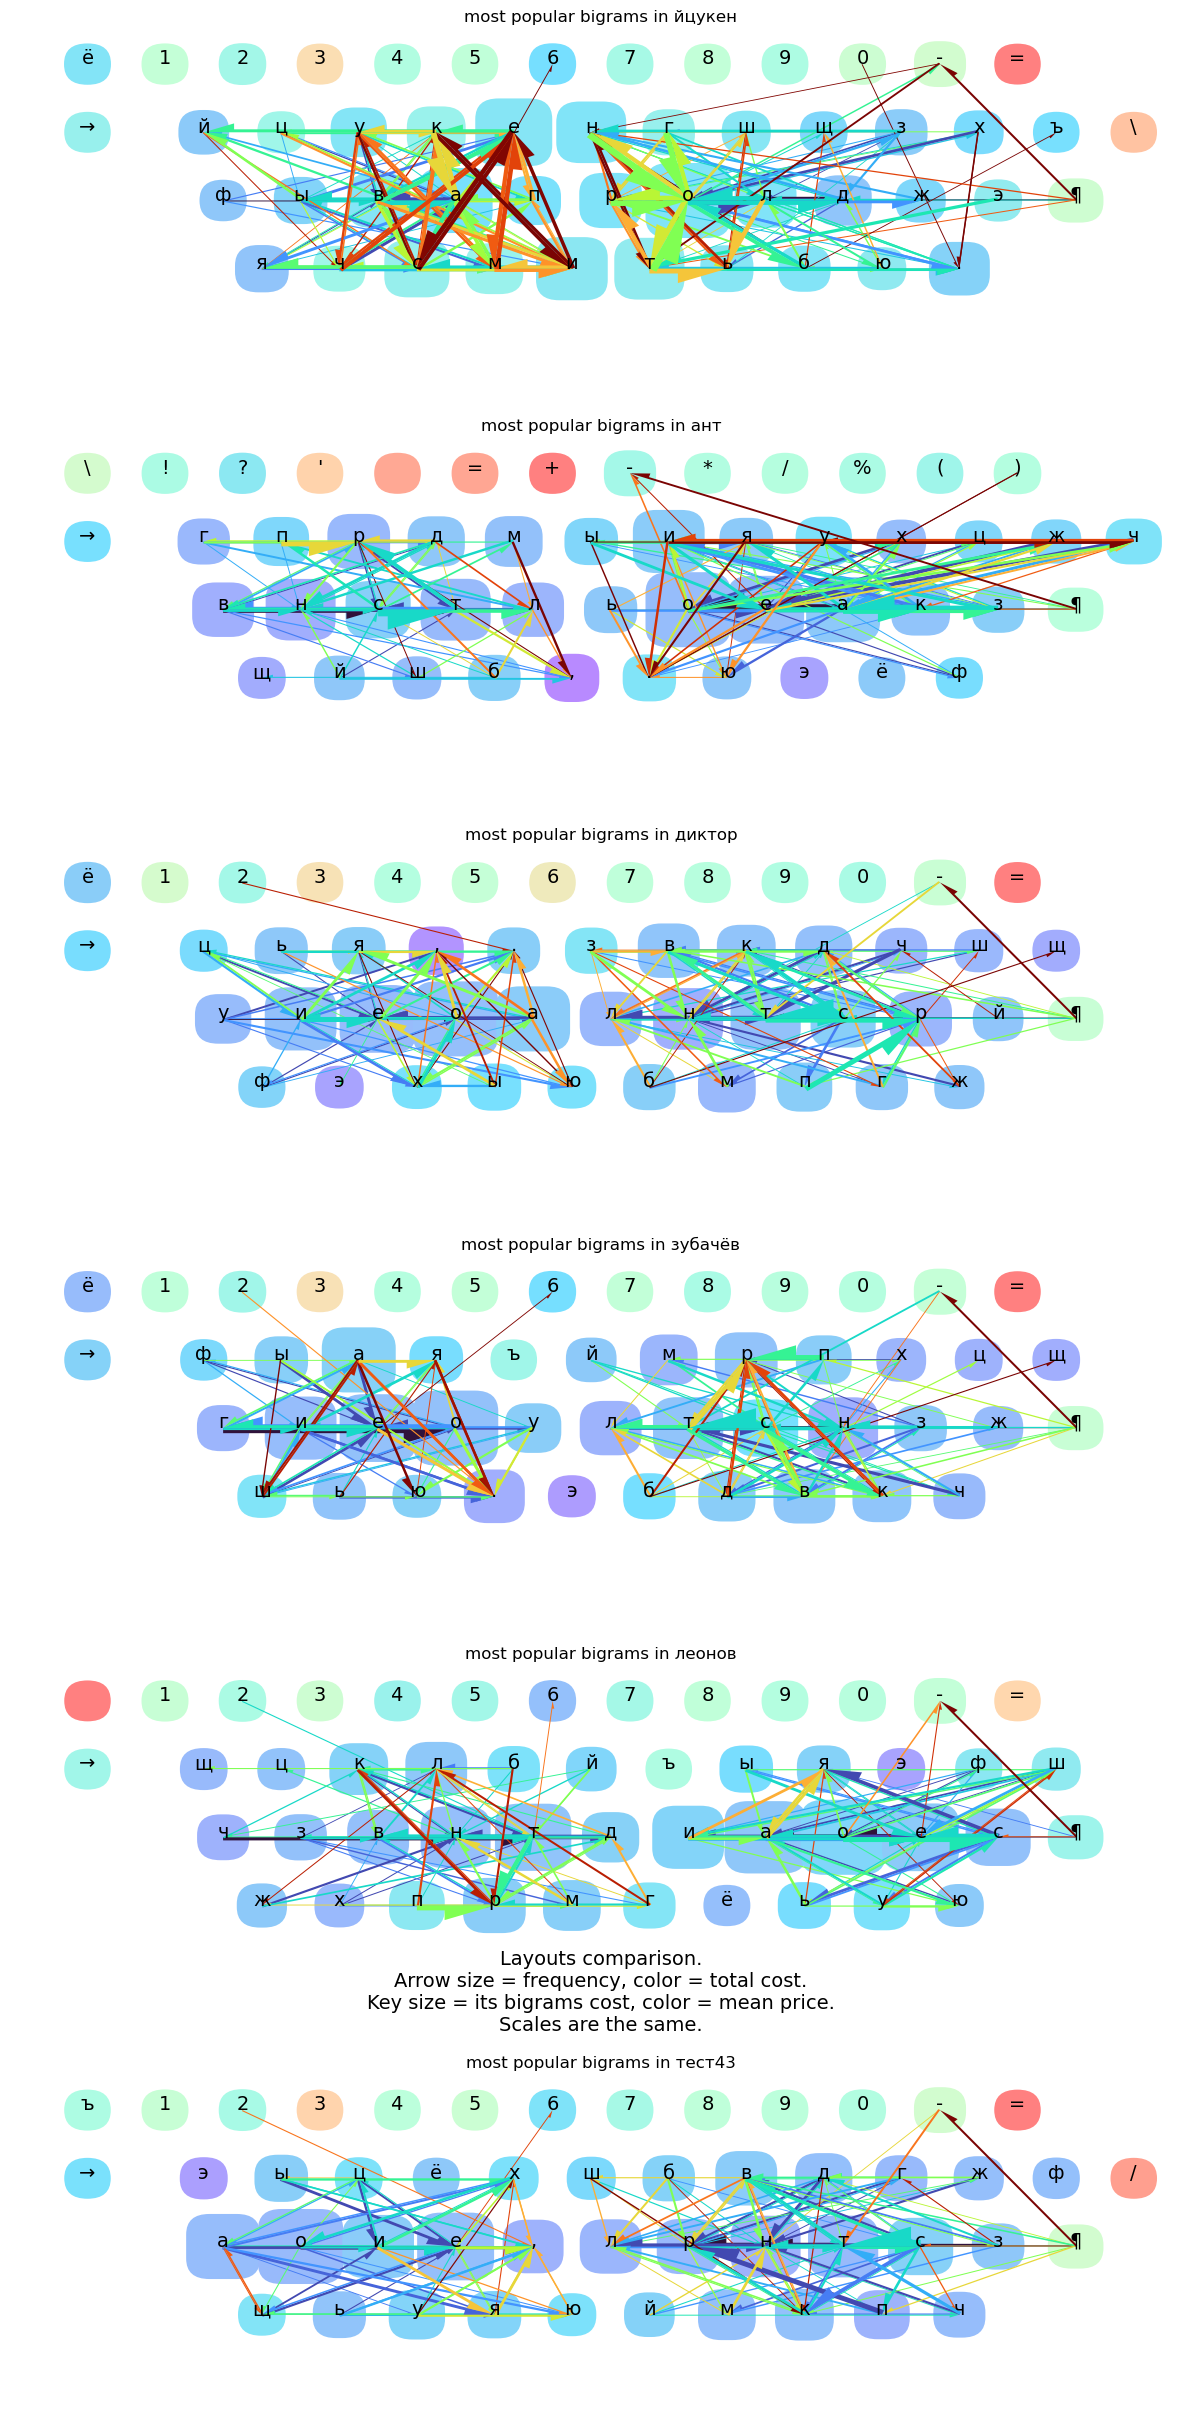

In [195]:
rs = results
rs['йцукен'].combomap(rs['ант'], rs['диктор'], rs['зубачёв'], rs['леонов'], rs['тест43'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

In [30]:
results['йцукен'].layout.keymap

layer  row  column  key_count
ё      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
й      0    1       1          1
ц      0    1       2          1
у      0    1       3          1
к      0    1       4          1
е      0    1       5          1
н      0    1       7          1
г      0    1       8          1
ш      0    1       9          1
щ      0    1      10          1
з      0    1      11          1
х      0    1      12          1
ъ      0    1      13          1
\      0    1      14          1
ф      0    2       1          1
ы      0    2       2          1
в      0    2       3          1
а      0    2       4          1
п      0    2       5          1
р      0    2       7          1
о      0    2       8          1
л      0    2       9          1
д      0    2      10          1
ж      0    2      11          1
э      0    2      12          1
¶      0    2      13          1
я      0    3       1          1
ч      0    3       2          1
с      0    3       3          1
м      0    3       4          1
и      0    3       5          1
т      0    3       7          1
ь      0    3       8          1
б      0    3       9          1
ю      0    3      10          1
.      0    3      11          1
⌴      0    4       0          1
~      1    0       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
,      1    3      11          1

/home/culebron/Soft/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


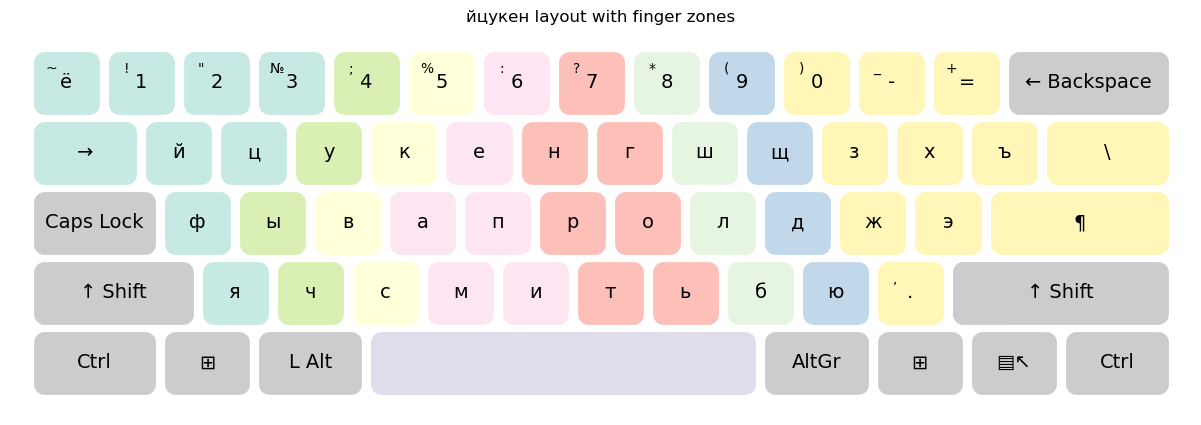

/home/culebron/Soft/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


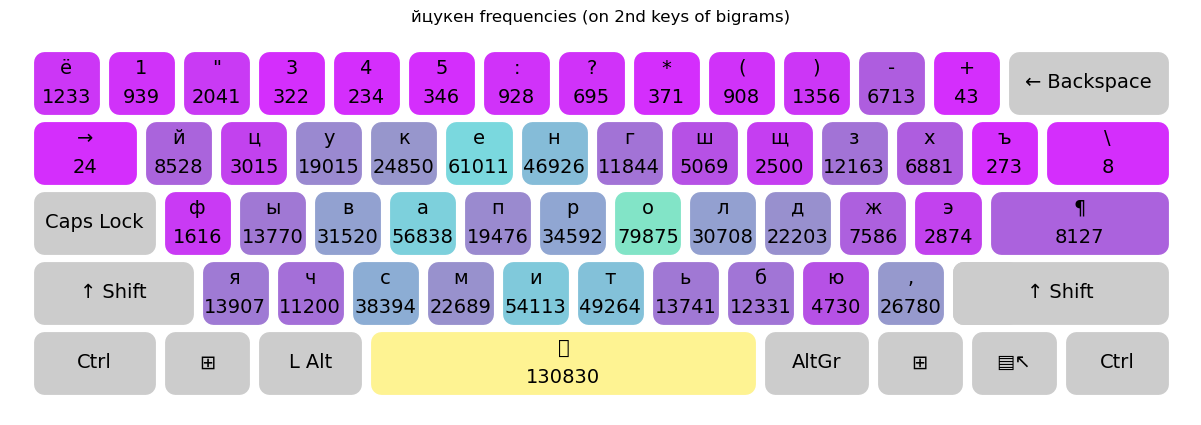

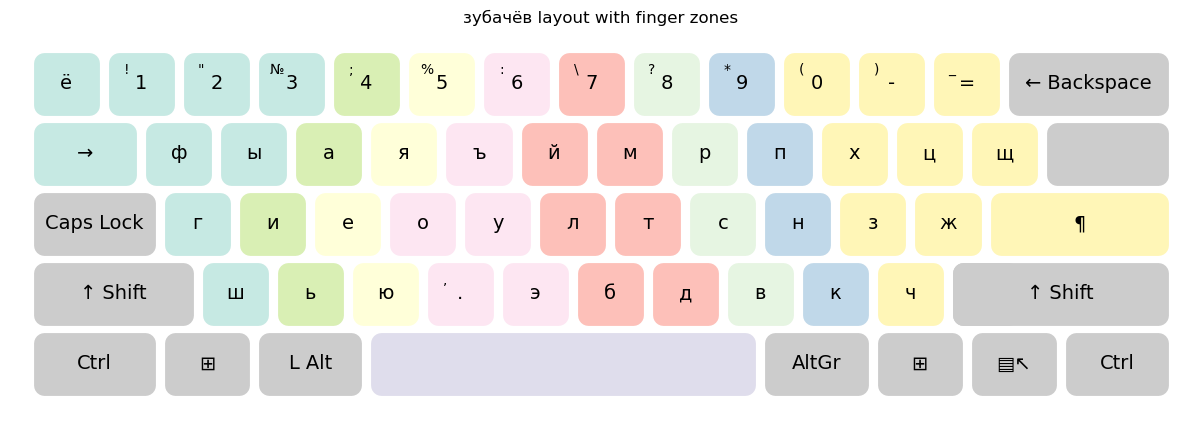

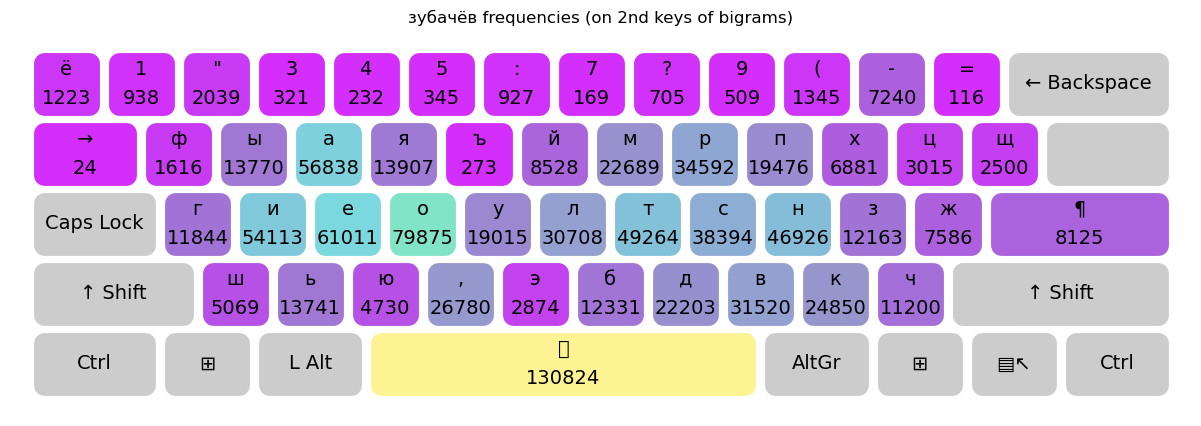

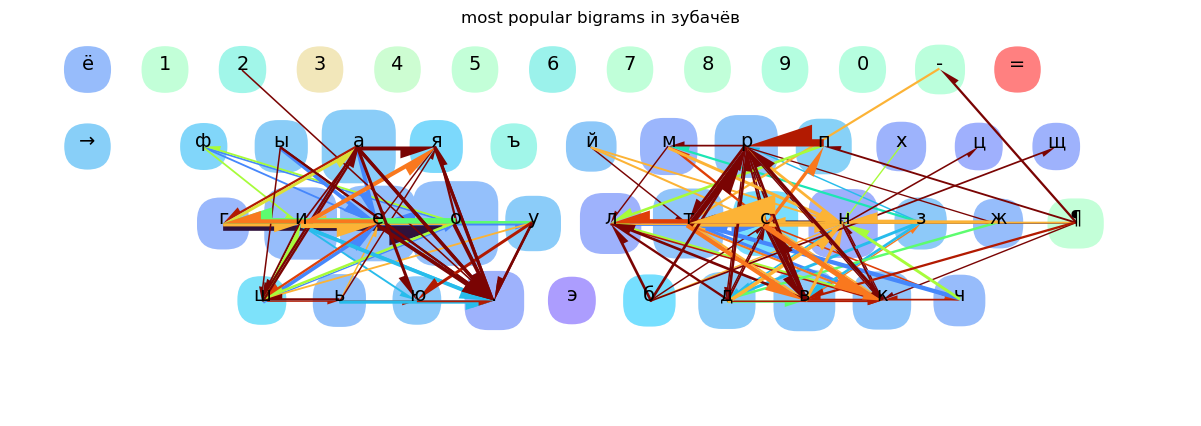

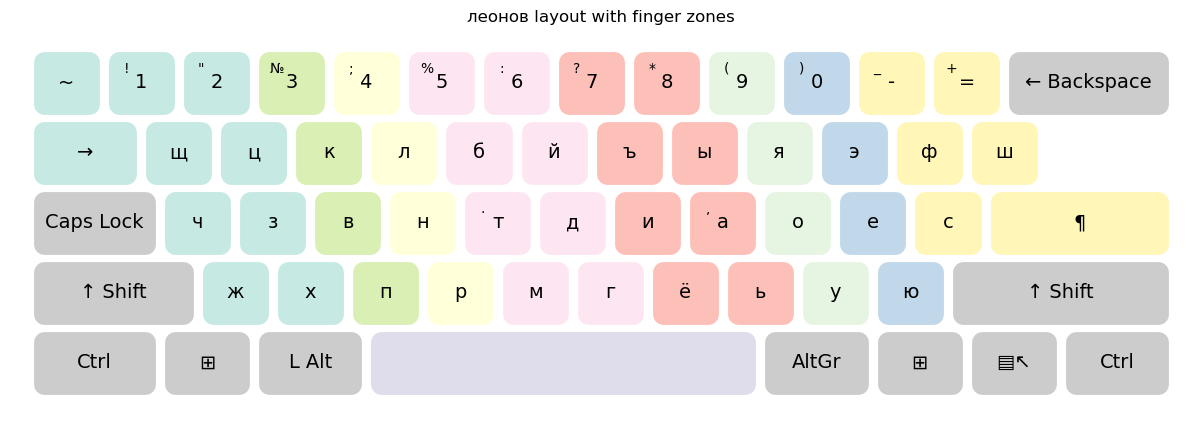

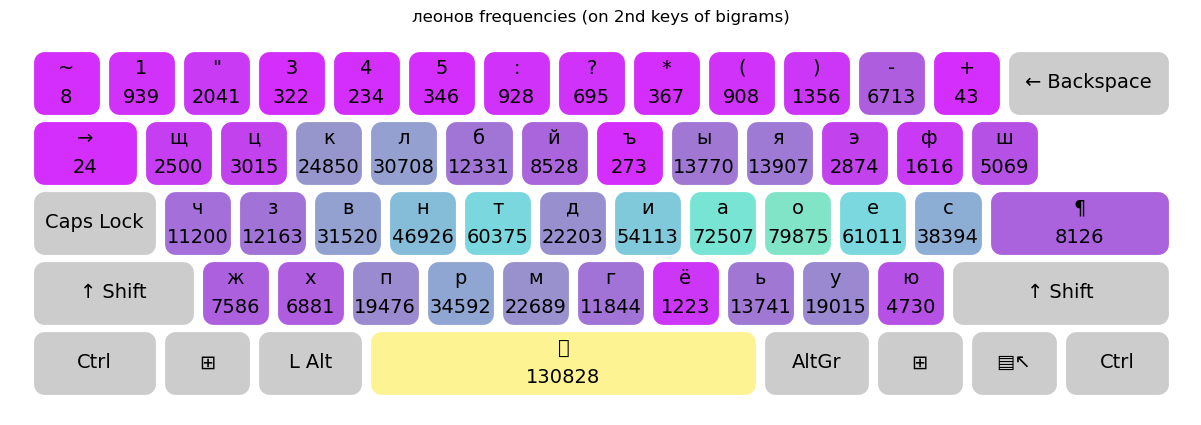

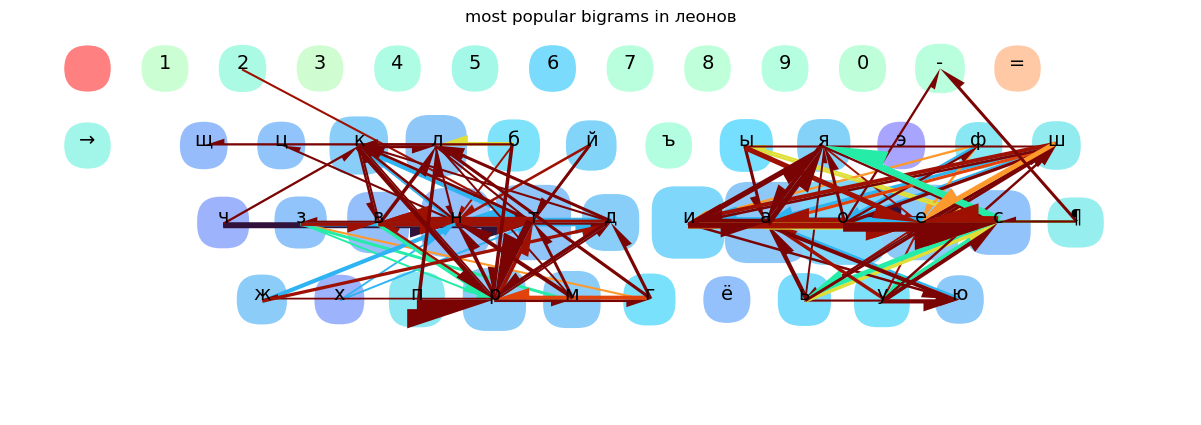

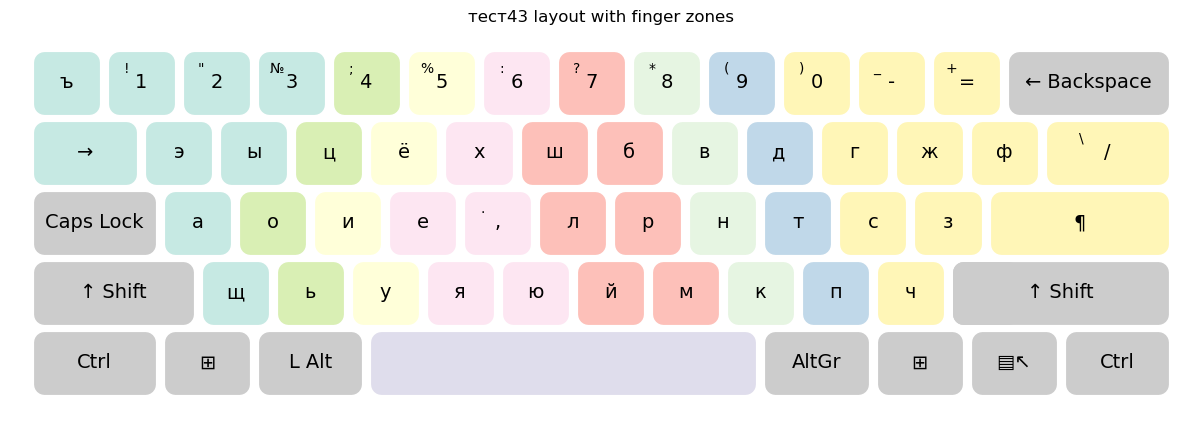

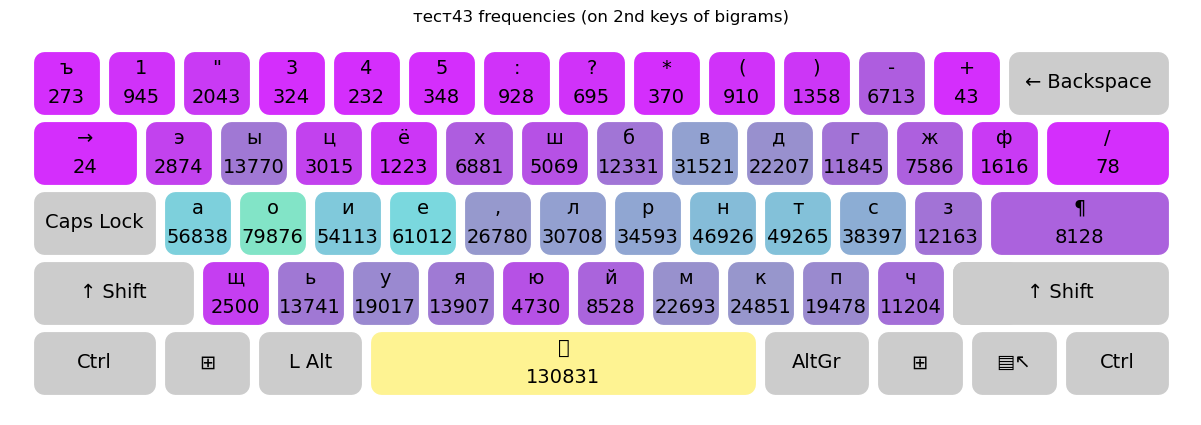

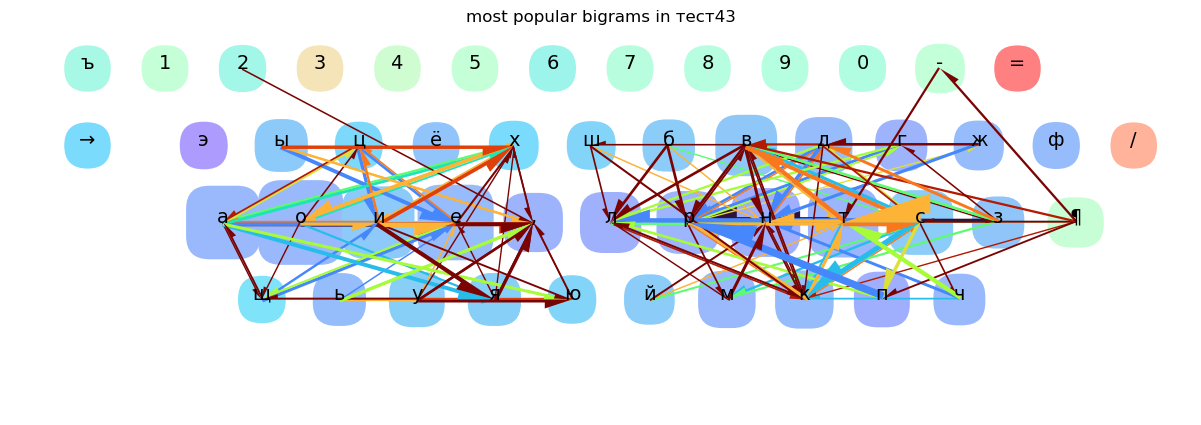

In [31]:
results['йцукен'].display('layout', 'num')
results['зубачёв'].display('layout', 'num', 'arrows')
results['леонов'].display('layout', 'num', 'arrows')
results['тест43'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [32]:
cmp = compare(results, 'леонов', 'тест43')
cmp.head(30)

bigram    num                coord_cat_old  coord_cost_old  move_cost_old  \
53      ¶¶   2870                     same key               0            1.0   
48      ст  10549                 altern hands               0            0.0   
125     --   2097                     same key               0           16.0   
177     .¶   3921                 altern hands               0            0.5   
18      ⌴в  11347                    space bar               0            0.0   
757     ¶-    586               pinky over row              12            4.0   
272     е,   1459  in, over 1 finger, same row               0            0.0   
463     вс   1832                 altern hands               0            0.0   
35      ов   6667                 altern hands               0            0.0   
194     хо   1638                 altern hands               0            0.0   
130     тс   1614                 altern hands               0            0.0   
350     я.    806                 altern hands               0            0.0   
134     чт   2120  in, over 1 finger, same row               0            0.0   
365     е.    905                 altern hands               0            0.0   
232     и.   1131                 altern hands               0            0.0   
111     их   1574                 altern hands               0            0.5   
457     -т    542                 altern hands               0            0.0   
364     шк    467                 altern hands               0            0.5   
294     вр    751                in, lower row               1            0.0   
71      ых   1340                 altern hands               0            0.5   
124     ⌴-   2268                    space bar               0            2.0   
338     вл    794      in, adj finger, adj row               4            0.0   
871     ща    415                 altern hands               0            0.0   
346     бл    789       index->middle same row               1            1.0   
105     на   8004                 altern hands               0            0.0   
10      ра   7597                 altern hands               0            0.0   
94      ⌴з   3467                    space bar               0            0.0   
14      тн   1148       index->middle same row               1            0.0   
445     зд    979  in, over 1 finger, same row               0            0.0   
273     ¶в    589                 altern hands               0            0.0   

             move_cat_old  cost_old                          coord_cat_new  \
53                     ok    5740.0                               same key   
48   alternating or space       0.0                in, adj finger, adj row   
125                    ok   36697.5                               same key   
177  alternating or space    5881.5                           altern hands   
18   alternating or space       0.0                              space bar   
757                    ok   10255.0                         pinky over row   
272                    ok       0.0                    same finger adj row   
463  alternating or space     916.0                   out, over one finger   
35   alternating or space       0.0                           altern hands   
194  alternating or space       0.0                   out, over one finger   
130  alternating or space     807.0                   out, over one finger   
350  alternating or space       0.0                    same finger adj row   
134                    ok       0.0                pinky -> ring, next row   
365  alternating or space       0.0                    same finger adj row   
232  alternating or space       0.0                in, adj finger, adj row   
111  alternating or space    2361.0  in, middle to to index in a row below   
457  alternating or space       0.0                    adj finger over row   
364  alternating or space     467.0                    adj finger over row   
294       

In [33]:
cmp.tail(30)

bigram   num                              coord_cat_old  coord_cost_old  \
344     ши  1006                 in, over 1 finger, adj row               1   
9       ⌴р  4077                                  space bar               0   
345     рн   846                        same finger adj row               6   
110     ки  2886                               altern hands               0   
164     о,  1483                    in, adj finger, adj row               4   
324     бр   812                        adj finger over row              10   
218     ше  1528                    pinky -> ring, next row               3   
211     ер  4780                               altern hands               0   
156     ис  2458                             index -> pinky               2   
79      ⌴г  3298                                  space bar               0   
153     ог  3341                               altern hands               0   
256     ые  1696                       out, over one finger               4   
33      ти  3904                               altern hands               0   
69      ор  5921                               altern hands               0   
489     гл   645                        adj finger over row              10   
129     ае  1585                       out, over one finger               4   
28      ри  4244                               altern hands               0   
238     ас  3302                             index -> pinky               2   
252     пл   786                        adj finger over row              10   
184     ое  1888                       out, over one finger               4   
7       ли  5507                               altern hands               0   
31      кр  1386                        adj finger over row              10   
404     се  2650                    in, adj finger, adj row               4   
15      ни  7156                               altern hands               0   
277     ая  1782  out, from index in a row above, to middle               8   
23      ⌴и  9284                                  space bar               0   
78      тр  3288  out, from index in a row below, to middle               4   
61      ес  4129                       out, over one finger               4   
56      ос  5489                       out, over one finger               4   
41      пр  6010                    in, adj finger, adj row               4   

     move_cost_old          move_cat_old  cost_old  \
344            2.0                    ok    4024.0   
9              0.5  alternating or space    4077.0   
345            0.0                    ok    5076.0   
110            0.5  alternating or space    4329.0   
164            0.0                    ok    5932.0   
324            1.0                    ok    9338.0   
218            0.0                    ok    4584.0   
211            0.5  alternating or space    4780.0   
156            0.0                    ok    6145.0   
79             1.0  alternating or space    9894.0   
153            1.0  alternating or space   10023.0   
256            0.0                    ok    6784.0   
33             0.5  alternating or space    5856.0   
69             0.5  alternating or space    5921.0   
489            2.0                    ok    8062.5   
129            0.0                    ok    6340.0   
28             0.5  alternating or space    6366.0   
238            0.0                    ok    8255.0   
252            1.0                    ok    9039.0   
184            0.0                    ok    7552.0   
7              0.5  alternating or space    8260.5   
31             1.0                    ok   15939.0   
404            0.0                    ok   10600.0   
15             0.5  alternating or space   10734.0   
277            0.0                    ok   15147.0   
23             0.5  alternating or space   13926.0   
78             0.0                    ok   14796.0   
61             0.0                    ok  

In [37]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м   159  ¶  м  -  c  0.000175
1        мо  3241  м  о  c  v  0.003562
2        ож  1890  о  ж  v  c  0.002077
3        же  2825  ж  е  c  v  0.003104
4        ет  5188  е  т  v  c  0.005701
...     ...   ... .. .. .. ..       ...
2584     г!     1  г  !  c  -  0.000001
2585     v¶     3  v  ¶  -  -  0.000003
2586     ⌴?     2  ⌴  ?  -  -  0.000002
2587     -ю     1  -  ю  -  v  0.000001
2588     кы     2  к  ы  c  v  0.000002

[2589 rows x 7 columns]

In [43]:
b1 = CORP.bigrams
b2 = b1[b1.l1.isin(BASE_KEYS_RU) & b1.l2.isin(BASE_KEYS_RU)]
dists = b2.pivot_table('num', 'l1', 'l2').fillna(0)

In [44]:
npdist = dists.to_numpy()

In [42]:
from sklearn.cluster import AgglomerativeClustering

In [45]:
AgglomerativeClustering(metric='precomputed').fit(npdist)

ValueError: precomputed was provided as metric. Ward can only work with euclidean distances.